In [2]:
import numpy as np
import scipy.signal

import core
import torch
import torch.nn as nn
from torch.nn import Transformer
import torch.nn.functional as F
from torch.distributions.normal import Normal


def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])


LOG_STD_MAX = 2
LOG_STD_MIN = -20

class SquashedGaussianMLPActor(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit):
        super().__init__()
        self.net = mlp([obs_dim] + list(hidden_sizes), activation, activation)
        self.mu_layer = nn.Linear(hidden_sizes[-1], act_dim)
        self.log_std_layer = nn.Linear(hidden_sizes[-1], act_dim)
        self.act_limit = act_limit

    def forward(self, obs, deterministic=False, with_logprob=True):
        net_out = self.net(obs)
        mu = self.mu_layer(net_out)
        log_std = self.log_std_layer(net_out)
        log_std = torch.clamp(log_std, LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)

        # Pre-squash distribution and sample
        pi_distribution = Normal(mu, std)
        if deterministic:
            pi_action = mu
        else:
            pi_action = pi_distribution.rsample()

        if with_logprob:
            logp_pi = pi_distribution.log_prob(pi_action).sum(axis=-1)
            logp_pi -= (2*(np.log(2) - pi_action - F.softplus(-2*pi_action))).sum(axis=1)
        else:
            logp_pi = None

        pi_action = torch.tanh(pi_action)
        pi_action = self.act_limit * pi_action

        return pi_action, logp_pi
    
class MLPMutiQ(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.q1 = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)
        self.q2 = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)
        # self.q3 = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs, act):
        input = torch.cat([obs, act], dim=-1)
        q1 = self.q1(input)
        q2 = self.q2(input)
        # q3 = self.q3(input)

        output = torch.stack([torch.squeeze(q1, -1),torch.squeeze(q2, -1)])
        # output = torch.stack([torch.squeeze(q1, -1),torch.squeeze(q2, -1),torch.squeeze(q2, -1)])
        return output # Critical to ensure q has right shape.
    
class MLPActorCriticMutiQ(nn.Module):

    def __init__(self, observation_space, action_space, num_out=10, hidden_sizes=(256,256),
                 activation=nn.ReLU):
        super().__init__()

        obs_dim = observation_space.shape[0]
        act_dim = action_space.shape[0]
        act_limit = action_space.high[0]

        # build policy and value functions
        self.pi = SquashedGaussianMLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit)
        self.value = MLPMutiQ(obs_dim,act_dim,hidden_sizes=hidden_sizes,activation=activation)
        self.alpha_net = mlp([obs_dim] + [obs_dim,obs_dim] + [1], activation)

    def act(self, obs, deterministic=False):
        with torch.no_grad():
            a, _, = self.pi(obs, deterministic, False)
            return a.numpy()
        
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for SAC agents.
    """

    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(core.combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(core.combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(core.combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}



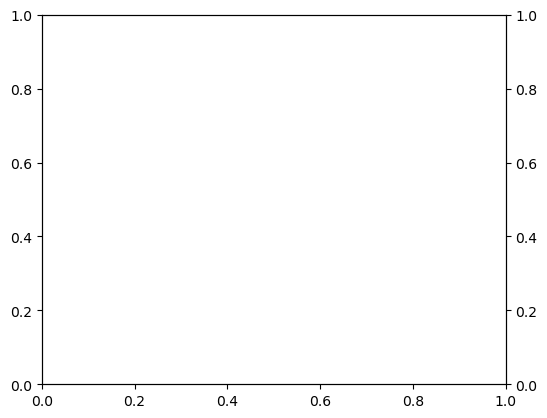

In [3]:
from copy import deepcopy
import itertools
import numpy as np
import pandas as pd
import torch
from torch.optim import Adam
import gymnasium as gym
import time
import core
from tqdm import tqdm



from matplotlib import pyplot as plt
import matplotlib

is_ipython = 'inline' in matplotlib.get_backend()
from IPython import display
# plt.ion()

fig, ax1 = plt.subplots()
fig.subplots_adjust(right=0.85)
ax2 = ax1.twinx()
def plot_durations(steps_per_epoch,history_rewards,alpha_history,env_name,save_fig=False):
    # display.clear_output(wait=True)
    ax1.clear()
    ax2.clear()
    t = [i*steps_per_epoch for i in range(len(history_rewards))]

    color = 'tab:red'
    ax1.set_title('Training...')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Duration')
    ax1.plot(t,history_rewards,color=color)
    ax1.hlines(max(history_rewards),xmin=0,xmax=len(history_rewards)*steps_per_epoch,color='orange',linestyles='dashdot')
    ax1.tick_params(axis='y', labelcolor=color)

    # ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('alpha', color=color)  # we already handled the x-label with ax1
    ax2.yaxis.set_label_position('right')
    ax2.plot(t,alpha_history, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # plt.pause(0.001)  # pause a bit so that plots are updated
    # fig.tight_layout()
    # plt.show()
    # display.display(fig)
    fig.savefig(f"./mutiQ_{env_name}")


def sac(env,test_env,env_name, actor_critic=MLPActorCriticMutiQ, ac_kwargs=dict(), seed=0, 
        steps_per_epoch=4000, epochs=100, replay_size=int(1e6), gamma=0.99, 
        polyak=0.995, lr=1e-3, alpha_base =0.2, final_entropy=-1,alpha_lr=1e-4, batch_size=100, start_steps=10000, 
        update_after=1000, update_every=1, num_test_episodes=10, max_ep_len=1000, lta = 1,
        logger_kwargs=dict(), save_freq=1):
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    history_rewards = []
    history_avg_alpha = []

    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape[0]

    # Action limit for clamping: critically, assumes all dimensions share the same bound!
    act_limit = env.action_space.high[0]

    # Create actor-critic module and target networks
    ac = actor_critic(env.observation_space, env.action_space, **ac_kwargs)
    with torch.no_grad():
        for p in ac.alpha_net.parameters():
            p[:] = 0
    ac_targ = deepcopy(ac)
    

    # Freeze target networks with respect to optimizers (only update via polyak averaging)
    for p in ac_targ.parameters():
        p.requires_grad = False
        
    # Experience buffer
    replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size)

    # Set up optimizers for policy and q-function
    pi_optimizer = Adam(ac.pi.parameters(), lr=lr)
    q_optimizer = Adam(ac.value.parameters(), lr=lr)
    alpha_optimizer = Adam(ac.alpha_net.parameters(), lr=alpha_lr)

    # unit_tensor = torch.tensor(np.zeros(obs_dim),dtype=torch.float32)


    def update(data):

        # First run one gradient descent step for Q1 and Q2
        o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']
        r = r * 5
        
        log_alpha = ac.alpha_net(prev_o + lta * (o - prev_o))
        # alpha = log_alpha
        alpha = torch.exp(log_alpha) + alpha_base
        # alpha = torch.sigmoid(log_alpha) + alpha_base
        q_optimizer.zero_grad()
        qs = ac.value(o,a)

        with torch.no_grad():
            a2, logp_a2 = ac.pi(o2)

            q_targs = ac_targ.value(o2,a2)
            q_targs_min = q_targs.min(dim=0)[0]

            backup = r + gamma * (1 - d) * (q_targs_min - alpha.detach() * logp_a2)
        loss_q = ((qs[0] - backup)**2).mean()
        for q in qs[1:]:
            loss_q += ((q - backup)**2).mean()
        loss_q.backward()
        q_optimizer.step()
        
        
        for p in ac.value.parameters():
            p.requires_grad = False

        pi_optimizer.zero_grad()
        pi, logp_pi = ac.pi(o)

        qs_pi = ac.value(o,pi)
        q_pi_min = qs_pi.min(dim=0)[0]

        loss_pi = (alpha.detach() * logp_pi - q_pi_min).mean()
        loss_pi.backward()
        pi_optimizer.step()

        for p in ac.value.parameters():
            p.requires_grad = True

        # alpha_loss = -(alpha * (logp_pi.detach() + final_entropy)).mean()
        alpha_loss = -(log_alpha * (logp_pi.detach() + final_entropy)).mean()
        alpha_optimizer.zero_grad()
        alpha_loss.backward()
        alpha_optimizer.step()
        log_alpha = log_alpha + alpha_loss + 1 * ac.alpha_net(o2 - o)


        with torch.no_grad():
            for p, p_targ in zip(ac.parameters(), ac_targ.parameters()):
                p_targ.data.mul_(polyak)
                p_targ.data.add_((1 - polyak) * p.data)

        return alpha.detach()

    def get_action(o, deterministic=False):
        return ac.act(torch.as_tensor(o, dtype=torch.float32), 
                      deterministic)

    def test_agent():
        ep_rets = []
        for j in range(num_test_episodes):
            (o,_), d, ep_ret, ep_len = test_env.reset(), False, 0, 0
            while not(d or (ep_len == max_ep_len)):
                # Take deterministic actions at test time 
                o, r, termin, tunc, _ = test_env.step(get_action(o, True))
                d = termin or tunc
                ep_ret += r
                ep_len += 1
            ep_rets.append(ep_ret)
        return np.average(ep_rets)

    # Prepare for interaction with environment
    total_steps = steps_per_epoch * epochs
    start_time = time.time()
    (o,_), ep_ret, ep_len = env.reset(), 0, 0

    # Main loop: collect experience in env and update/log each epoch
    pbar = tqdm(range(total_steps))
    for t in pbar:
        if t > start_steps:
            a = get_action(o)
        else:
            a = env.action_space.sample()

        # Step the env
        o2, r, termin, tunc, _ = env.step(a)
        d = termin or tunc
        ep_ret += r
        ep_len += 1

        d = False if ep_len==max_ep_len else d

        replay_buffer.store(o, a, r, o2, d)
        o = o2

        if d or (ep_len == max_ep_len):
            (o,_), ep_ret, ep_len = env.reset(), 0, 0

        init = True
        # Update handling
        if t >= update_after and t % update_every == 0:
            for j in range(update_every):
                batch = replay_buffer.sample_batch(batch_size)
                if init:
                    prev_o = batch['obs']
                    init = False
                alpha = update(data=batch)
                prev_o = batch['obs']

        # End of epoch handling
        if (t+1) % steps_per_epoch == 0:
            epoch = (t+1) // steps_per_epoch

            avg_reward = test_agent()
            history_rewards.append(avg_reward)
            with torch.no_grad():
                history_avg_alpha.append(alpha.mean().numpy())
            
            plot_durations(steps_per_epoch,history_rewards,history_avg_alpha,env_name,False)
            pd.DataFrame(np.transpose([history_rewards,history_avg_alpha]),columns=['reward','alpha']).to_csv(f"./mutiQ_{env_name}.csv")

            pbar.set_description_str(f"avg_reward: {avg_reward:.2f}")

    return ac,ac_targ


In [ ]:
torch.set_num_threads(torch.get_num_threads())
lta = 10

for i in range(0,5):
    env_name = 'Ant-v4'
    sac(gym.make(env_name),gym.make(env_name),env_name=env_name + f'-lta = {lta}-' + str(i)+'.png', actor_critic=MLPActorCriticMutiQ,
    ac_kwargs=dict(num_out=10,hidden_sizes=[256]*2), num_test_episodes=1, steps_per_epoch=4000, start_steps=10000, update_after=1000,
    alpha_base=0,final_entropy=-8,alpha_lr=1e-3,lr=1e-3,batch_size=100,
    gamma=0.99, seed=np.random.randint(0,1000), epochs=750,lta = 0,
    logger_kwargs={})

avg_reward: 987.18:  28%|██▊       | 842461/3000000 [1:57:31<7:29:51, 79.93it/s]  